## Carregando o dataset elaborado pelo roboflow

In [1]:
!pip install roboflow
import tensorflow as tf
from roboflow import Roboflow
rf = Roboflow(api_key="8s5j2WfAsI1kEYNbgAZx")
project = rf.workspace("cesar-kkubx").project("deep-learning-animals")
dataset = project.version(2).download("folder")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.2 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=e23964180d64dd4a606777f72c48aafe9761b6ef8dfe149a6f98f472a8b7e4d5
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to deep-learning-animals-2 in folder:: 100%|██████████| 330/330 [00:00<00:00, 1079.57it/s]


Atribuindo variáveis para conter o treino e a validação

In [2]:
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder('deep-learning-animals-2/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='deep-learning-animals-2/',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=4),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=238, num_shards=1>,
        'valid': <SplitInfo num_examples=80, num_shards=1>,
    },
    citation="""""",
)


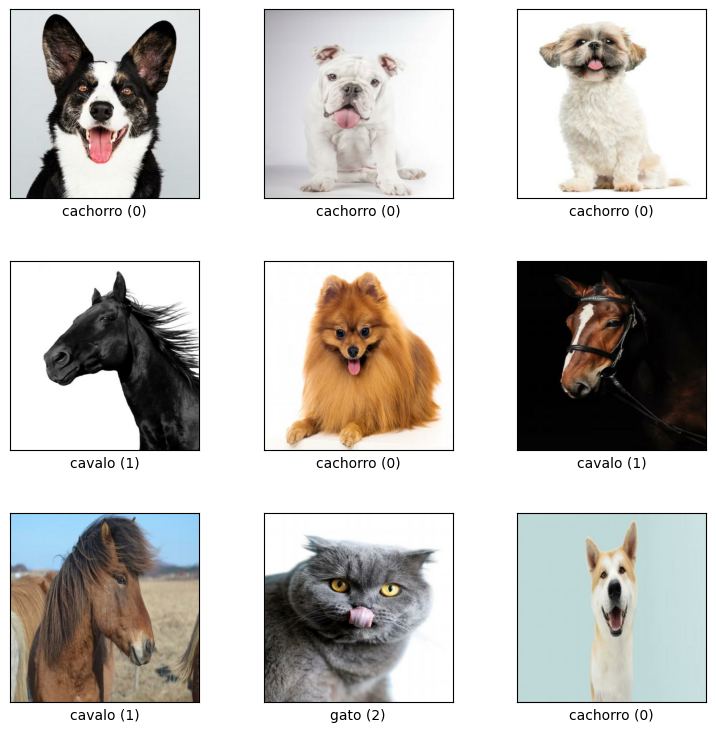

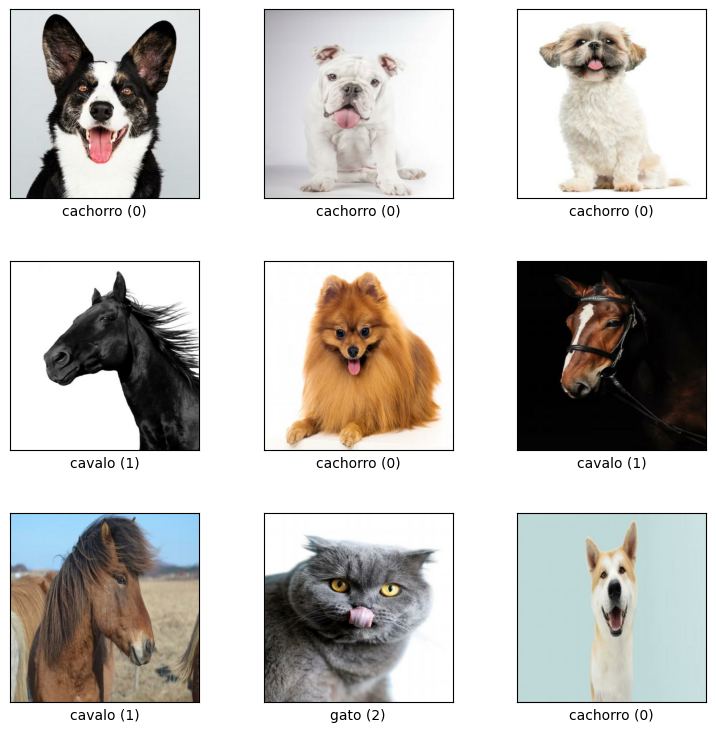

In [3]:
tfds.show_examples(raw_train, builder.info)

In [4]:
IMG_SIZE = 640

def format_example(pair):
  image, label = pair['image'], tf.one_hot(pair['label'], 4)
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label



train = raw_train.map(format_example)
validation = raw_valid.map(format_example)

In [5]:
BATCH_SIZE = 15
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape
     


TensorShape([15, 640, 640, 3])

In [6]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Modelo
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
feature_batch = base_model(image_batch)
base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 320, 320, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 320, 320, 32  128         ['Conv1[0][0]']                  
                

In [7]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [8]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(15, 4)


In [9]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 20, 20, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
validation_steps = 20
initial_epochs = 25

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)


 6/20 [========>.....................] - ETA: 4s - loss: 0.7627 - accuracy: 0.2000

20/20 [==============================] - 9s 125ms/step - loss: 0.7627 - accuracy: 0.2000


In [11]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.76
initial accuracy: 0.20


In [12]:
%pip install -q wandb
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


In [13]:
import sys

def wandb_colab_login():
  """Temporary hack to prevent colab from hanging"""
  sys.modules["google.colab2"] = sys.modules["google.colab"]
  del sys.modules["google.colab"]
  wandb.login()
  sys.modules["google.colab"] = sys.modules["google.colab2"]
wandb_colab_login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [14]:
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches,
                    callbacks=[cp_callback])

Epoch 1/25
16/16 [==============================] - ETA: 0s - loss: 0.5261 - accuracy: 0.5126
Epoch 1: saving model to training_1/cp.ckpt
16/16 [==============================] - 15s 443ms/step - loss: 0.5261 - accuracy: 0.5126 - val_loss: 0.4748 - val_accuracy: 0.4625
Epoch 2/25
16/16 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.7815
Epoch 2: saving model to training_1/cp.ckpt
16/16 [==============================] - 9s 298ms/step - loss: 0.4015 - accuracy: 0.7815 - val_loss: 0.3799 - val_accuracy: 0.9125
Epoch 3/25
16/16 [==============================] - ETA: 0s - loss: 0.3310 - accuracy: 0.9202
Epoch 3: saving model to training_1/cp.ckpt
16/16 [==============================] - 6s 284ms/step - loss: 0.3310 - accuracy: 0.9202 - val_loss: 0.3169 - val_accuracy: 0.8875
Epoch 4/25
16/16 [==============================] - ETA: 0s - loss: 0.2817 - accuracy: 0.9538
Epoch 4: saving model to training_1/cp.ckpt
16/16 [==============================] - 6s 272ms/step

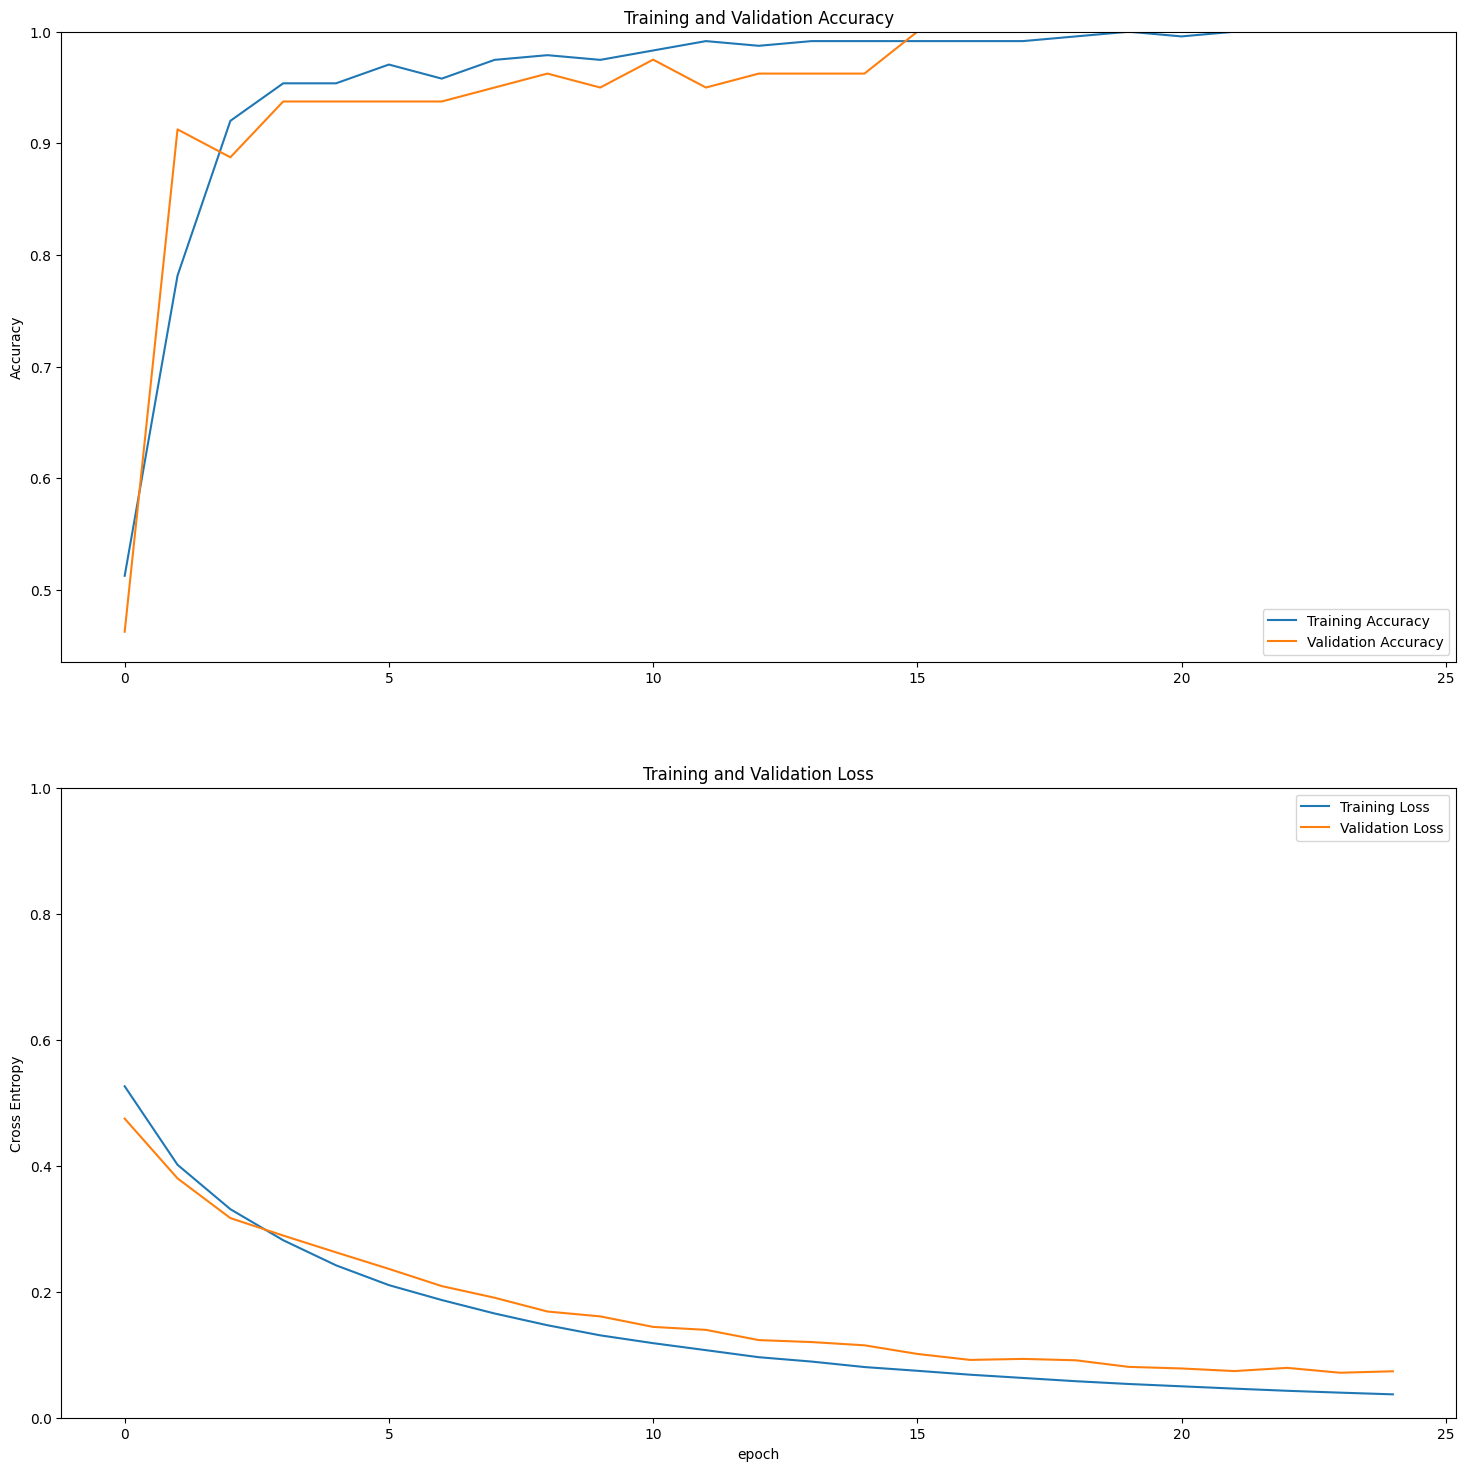

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(18, 18))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
!pip install pyyaml h5py

import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.12.0


In [17]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [18]:
# my_model directory
%ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
%ls saved_model/my_model

my_model/
assets/  fingerprint.pb  keras_metadata.pb  saved_model.pb  variables/


In [19]:

new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 20, 20, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
!mkdir /content/drive/MyDrive/Animals/model

mkdir: cannot create directory ‘/content/drive/MyDrive/Animals/model’: No such file or directory


In [22]:
!cp -r saved_model /content/drive/MyDrive/Animals/model

cp: cannot create directory '/content/drive/MyDrive/Animals/model': No such file or directory


In [23]:
!zip -r modelo.zip saved_model/my_model/ 

  adding: saved_model/my_model/ (stored 0%)
  adding: saved_model/my_model/assets/ (stored 0%)
  adding: saved_model/my_model/saved_model.pb (deflated 91%)
  adding: saved_model/my_model/variables/ (stored 0%)
  adding: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/my_model/variables/variables.index (deflated 76%)
  adding: saved_model/my_model/keras_metadata.pb (deflated 96%)
  adding: saved_model/my_model/fingerprint.pb (stored 0%)


In [24]:
!mkdir /content/drive/MyDrive/Animals/model/weights
     

mkdir: cannot create directory ‘/content/drive/MyDrive/Animals/model/weights’: No such file or directory


In [25]:
!cp -r /content/training_1 /content/drive/MyDrive/Animals/model/weights


cp: cannot create directory '/content/drive/MyDrive/Animals/model/weights': No such file or directory


In [26]:
!zip -r weights.zip /content/training_1

  adding: content/training_1/ (stored 0%)
  adding: content/training_1/cp.ckpt.data-00000-of-00001 (deflated 7%)
  adding: content/training_1/cp.ckpt.index (deflated 78%)
  adding: content/training_1/checkpoint (deflated 38%)


In [27]:
base_model.trainable = True

In [28]:

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 20, 20, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 1,866,564
Non-trainable params: 396,544
_________________________________________________________________


In [30]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 25/35
16/16 [==============================] - 22s 424ms/step - loss: 0.1733 - accuracy: 0.9454 - val_loss: 0.1514 - val_accuracy: 0.9000
Epoch 26/35
16/16 [==============================] - 6s 302ms/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.1555 - val_accuracy: 0.8625
Epoch 27/35
16/16 [==============================] - 6s 324ms/step - loss: 0.0179 - accuracy: 0.9958 - val_loss: 0.1599 - val_accuracy: 0.8875
Epoch 28/35
16/16 [==============================] - 5s 269ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.1325 - val_accuracy: 0.9125
Epoch 29/35
16/16 [==============================] - 6s 302ms/step - loss: 0.0140 - accuracy: 0.9958 - val_loss: 0.1914 - val_accuracy: 0.8625
Epoch 30/35
16/16 [==============================] - 6s 302ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.2027 - val_accuracy: 0.8750
Epoch 31/35
16/16 [==============================] - 6s 318ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.1990 - val_accuracy: 0.900